In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.vllm import start_vllm_server, vllm_server_metrics
import os

model = "NousResearch/Hermes-2-Theta-Llama-3-8B"

os.environ["VLLM_ALLOW_LONG_MAX_MODEL_LEN"] = "1"
shutdown_server, client = await start_vllm_server(
    disable_log_requests=True,
    max_model_len=16384,
    gpu_memory_utilization=0.66,
    model=model,
)

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION
/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION
Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.07s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.09s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.34it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.15it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.12it/s]



In [ ]:
from lib.utils import black_print

black_print(
    await client.chat.completions.create(
        messages=[
            {"role": "user", "content": "Hello"},
            {"role": "assistant", "content": "My favorite color is"},
        ],
        model=model,
        extra_body={
            "add_generation_prompt": False,
            "continue_final_message": True,
            # "guided_regex": r" blue",
            # "guided_decoding_backend": "lm-format-enforcer",
        },
    )
)

In [3]:
import asyncio
from lib.clue import Clue, DeductiveSolver
from lib.rl import (
    Completion,
    CompletionSampler,
    Episode,
    EpisodeBuffer,
    EpisodeSampler,
    EpisodeSamplerRouter,
)
from lib.tokenizer import Tokenizer
import nest_asyncio
import re

nest_asyncio.apply()

In [45]:
shutdown_server()

False

In [4]:
def sample_random_episode() -> Episode:
    game = Clue(
        num_players=3,
        elements={
            "suspect": Clue.suspects[:3],
            "weapon": Clue.weapons[:3],
            "room": Clue.rooms[:3],
            # "motive": Clue.motives[:6],
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        cp_solver_max_solve_time_per_turn=0.01,
        check_cp_solver_grid=False,
        check_if_deductive_solver_and_cp_solver_grids_match=False,
        print_playthrough=False,
    )
    prompt = game.get_prompt()
    follow_up = "Fill out your answer like this:\n" + "\n".join(
        f"{element.capitalize()}: <#{element.upper()}#>" for element in game.elements
    )

    async def reward_completion(completion: Completion) -> None:
        chat_completion = await client.chat.completions.create(
            messages=completion.all_message_params()
            + [
                {"role": "user", "content": follow_up},
            ],
            model=model,
            temperature=0.0,
        )
        answer = chat_completion.choices[0].message.content
        assert answer
        completion.reward = sum(
            [
                bool(
                    re.search(
                        f"{element}: {solution}",
                        answer,
                        re.IGNORECASE,
                    )
                )
                for element, solution in game.solution.items()
            ]
        ) / len(game.solution)

    async def on_sample(completions: list[Completion]) -> None:
        await asyncio.gather(
            *[reward_completion(completion) for completion in completions]
        )
        for completion in completions:
            completion.commit()

    return Episode(
        messages=[{"role": "user", "content": prompt}],
        on_sample=on_sample,
    )

In [5]:
completion_sampler = CompletionSampler(
    client,
    max_concurrent_requests=128,
    model=model,
    temperature=1.0,
)

tokenizer = Tokenizer(model)

episode_buffer = EpisodeBuffer(
    episode_sampler_router=EpisodeSamplerRouter(
        EpisodeSampler(sample_random_episode),
        exploitation_factor=1.0,
        min_random_episode_sample_probability_half_life=40,
    ),
    completion_sampler=completion_sampler,
    tokenizer=tokenizer,
    branch_factor=5,
    split_method="prob",
    split_separators={"\n"},
    size=256,
    episode_decay=0.7,
    completion_decay=0.7,
    fork_decay=0.0,
    start_buffering=True,
)

In [48]:
episode_buffer.start_buffering()

True

In [11]:
episode_buffer.stop_buffering()

True

In [9]:
running, pending = vllm_server_metrics()
print(f"Running/Pending/HWM vLLM Requests: {running}/{pending}/{episode_buffer.max_running_requests}")
print("Number of Episodes:", len(episode_buffer.episodes))
print(
    "Pending Tasks:",
    sum(task._state == "PENDING" for task in episode_buffer.tasks.values()),
)
print(
    "Sampled Completions:",
    sum(episode.num_samples() for episode in episode_buffer.episodes),
)
print(
    "Average Absolute Advantage Per Token:",
    sum(
        episode.best_leaf(tokenizer, split_method="count").all_abs_advantage_per_token(tokenizer)
        for episode in episode_buffer.episodes
    )
    / max(len(episode_buffer.episodes), 1),
)

Running/Pending/HWM vLLM Requests: 134/155/137
Number of Episodes: 381
Pending Tasks: 276
Sampled Completions: 6484
Average Absolute Advantage Per Token: 0.0003314729626640884


In [7]:
from lib.rl.trajectory import get_trajectory_batch, Trajectory, Trajectories, trajectory_tensors, write_trajectory_batch
import matplotlib.pyplot as plt
import torch

tensors = Trajectories(dir="./data/trajectories", rows=1000, seqlen=8192).tensors
trajectory_sequences: list[list[Trajectory]] = []
total_abs_advantages = []

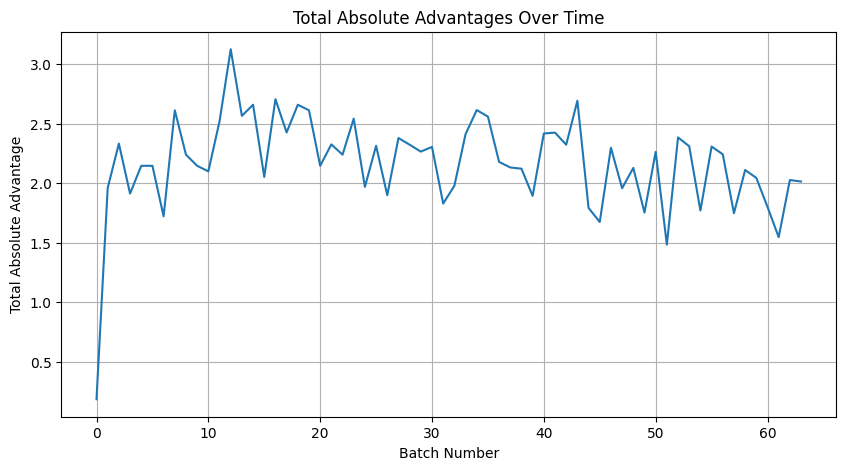

In [8]:
from IPython.display import clear_output

for _ in range(64):
    batch = await get_trajectory_batch(episode_buffer, 1, 8192)
    write_trajectory_batch(batch, tensors, len(trajectory_sequences))
    total_abs_advantages.append(
        torch.nansum(trajectory_tensors(batch, 8192)["advantages"].abs()).item()
    )
    trajectory_sequences += batch
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(total_abs_advantages)
    plt.title("Total Absolute Advantages Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Total Absolute Advantage")
    plt.grid(True)
    plt.show()
    await asyncio.sleep(6)

In [35]:
replacement_token = "<|reserved_special_token_250|>"

733

In [19]:
def token_logprobs(completion: Completion):
    if completion.parent:
        yield from token_logprobs(completion.parent)
    for sequence in completion._token_logprob_sequences():
        for token_logprob in sequence:
            yield token_logprob

In [31]:
from lib.rl.trajectory import Trajectories, write_trajectory_batch

tensors = Trajectories(dir="./data/trajectories", rows=len(trajectory_sequences), seqlen=8192).tensors
write_trajectory_batch(trajectory_sequences, tensors, 0)

In [30]:
(tensors['tokens'][3] == tensors['tokens'][2]).sum()

tensor(546)

In [27]:
episode_buffer.completion_sampler.client = client

In [10]:
all_prompt_logprobs = await asyncio.gather(
    *(trajectory._prompt_logprobs() for trajectory in trajectory_sequences[0])
)
all_prompt_logprobs

[[None,
  {'128002': {'logprob': -25.006452560424805,
    'rank': 99124,
    'decoded_token': '<|im_start|>'},
   '14924': {'logprob': -0.6042202711105347,
    'rank': 1,
    'decoded_token': 'Question'}},
  {'882': {'logprob': -18.07488441467285,
    'rank': 15450,
    'decoded_token': 'user'},
   '198': {'logprob': -0.07488424330949783, 'rank': 1, 'decoded_token': '\n'}},
  {'198': {'logprob': -9.464769391342998e-05,
    'rank': 1,
    'decoded_token': '\n'}},
  {'1966': {'logprob': -8.882420539855957, 'rank': 65, 'decoded_token': 'On'},
   '3923': {'logprob': -0.8377283811569214,
    'rank': 1,
    'decoded_token': 'What'}},
  {'264': {'logprob': -0.28056102991104126, 'rank': 1, 'decoded_token': ' a'}},
  {'8369': {'logprob': -7.121767044067383,
    'rank': 75,
    'decoded_token': ' warm'},
   '1396': {'logprob': -1.6692533493041992,
    'rank': 1,
    'decoded_token': ' number'}},
  {'10683': {'logprob': -5.935098648071289,
    'rank': 6,
    'decoded_token': ' spring'},
   '7474'

In [12]:
def fix_decoded_token(prompt_logprob: dict) -> dict:
    if prompt_logprob["decoded_token"] == "":
        prompt_logprob["decoded_token"] = "<|im_end|>"
    return prompt_logprob

prompt_logprobs = [
    fix_decoded_token(
        min(logprobs.values(), key=lambda x: x["logprob"])
        if logprobs
        else dict(logprob=-0.0, rank=1, decoded_token="<|begin_of_text|>")
    )
    for prompt_logprobs in all_prompt_logprobs
    for logprobs in prompt_logprobs
]
prompt_logprobs

[{'logprob': -0.0, 'rank': 1, 'decoded_token': '<|begin_of_text|>'},
 {'logprob': -25.006452560424805,
  'rank': 99124,
  'decoded_token': '<|im_start|>'},
 {'logprob': -18.07488441467285, 'rank': 15450, 'decoded_token': 'user'},
 {'logprob': -9.464769391342998e-05, 'rank': 1, 'decoded_token': '\n'},
 {'logprob': -8.882420539855957, 'rank': 65, 'decoded_token': 'On'},
 {'logprob': -0.28056102991104126, 'rank': 1, 'decoded_token': ' a'},
 {'logprob': -7.121767044067383, 'rank': 75, 'decoded_token': ' warm'},
 {'logprob': -5.935098648071289, 'rank': 6, 'decoded_token': ' spring'},
 {'logprob': -2.3366990089416504, 'rank': 2, 'decoded_token': ' evening'},
 {'logprob': -18.49350929260254, 'rank': 223, 'decoded_token': ' Isabel'},
 {'logprob': -3.004673480987549, 'rank': 4, 'decoded_token': ','},
 {'logprob': -12.450959205627441, 'rank': 571, 'decoded_token': ' Colin'},
 {'logprob': -0.39823320508003235, 'rank': 1, 'decoded_token': ','},
 {'logprob': -0.008805966004729271, 'rank': 1, 'decod

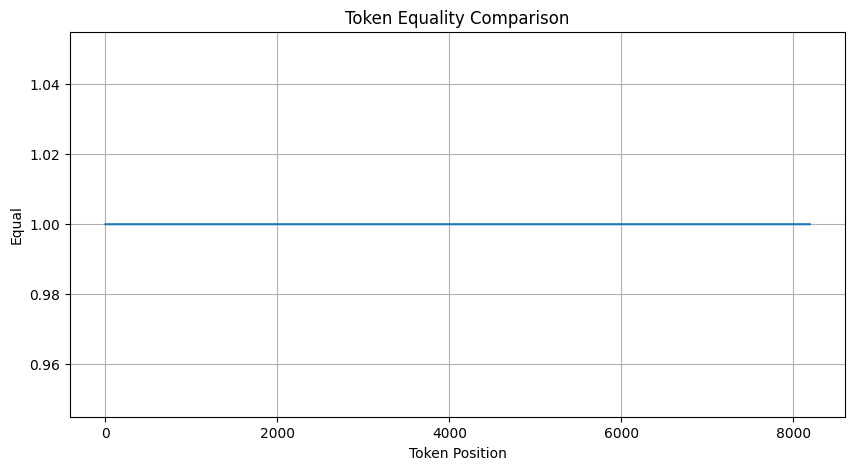

In [13]:
comparison = (
    tensors["tokens"][0]
    == torch.tensor(
        tokenizer.llm.get_tokenizer().encode(
            "".join(
                prompt_logprob["decoded_token"]
                for prompt_logprob in prompt_logprobs
            ),
            add_special_tokens=False,
            padding="max_length",
            max_length=8192,
        )
    )
)

plt.figure(figsize=(10,5))
plt.plot(comparison.numpy())
plt.title('Token Equality Comparison')
plt.xlabel('Token Position')
plt.ylabel('Equal')
plt.grid(True)
plt.show()

In [17]:
# Find first index where tokens are not equal
first_unequal = (comparison == False).nonzero()
if first_unequal.numel() > 0:
    print(first_unequal[0].item())  # Print column index of first unequal token
else:
    print("All tokens are equal")


1929


In [14]:
torch.corrcoef(
    torch.exp(
        torch.stack(
            [
                tensors["logprobs"][0],
                torch.tensor(
                    [prompt_logprob["logprob"] for prompt_logprob in prompt_logprobs]
                    + [-0.0] * (8192 - len(prompt_logprobs))
                ),
            ]
        )[:, ~torch.isnan(tensors["logprobs"][0])]
    )
)

tensor([[1.0000, 0.9872],
        [0.9872, 1.0000]])

In [17]:
for key, tensor in Trajectories(
    dir="./data/trajectories", rows=len(trajectory_sequences), seqlen=8192
).tensors.items():
    print(key, tensor[0, 605:620])

tokens tensor([  198, 10267,   596, 63179,   279,  7563,   430,  1051,  6982,  1473,
           16,    13, 19475,   574,  6982])
advantages tensor([    nan, -0.0015, -0.0015, -0.0015, -0.0015, -0.0015, -0.0015, -0.0015,
        -0.0015, -0.0015, -0.0015, -0.0015, -0.0015, -0.0015, -0.0015])
logprobs tensor([        nan, -4.1573e-01, -2.7563e-03, -3.8476e+00, -5.6124e-02,
        -1.6602e+00, -9.6587e-01, -3.7516e-01, -1.6100e-01, -1.2008e+00,
        -1.4359e+00, -6.0206e-04, -2.9678e-01, -1.9169e+00, -4.9866e-03])


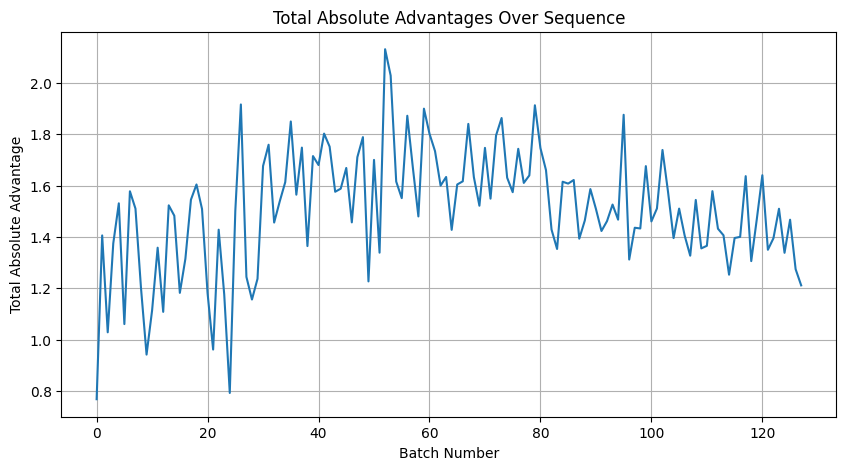

In [21]:
sequence_advantages = torch.nansum(Trajectories(dir="./data/trajectories", rows=len(trajectory_sequences), seqlen=8192).tensors["advantages"].abs(), axis=1)
plt.figure(figsize=(10,5))
plt.plot(sequence_advantages)
plt.title('Total Absolute Advantages Over Sequence')
plt.xlabel('Batch Number')
plt.ylabel('Total Absolute Advantage')
plt.grid(True)
plt.show()

In [25]:
torch.nansum(trajectory_batch_tensor_dict(trajectory_sequences, 8192)["advantages"].abs()).item()

3.817333459854126

In [18]:
from collections import Counter

Counter(task._state for task in episode_buffer.tasks.values())

Counter({'PENDING': 158, 'FINISHED': 98})

In [71]:
%%prun
asyncio.run(asyncio.sleep(10))

         4588552 function calls (4449198 primitive calls) in 10.034 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 1327/581    4.178    0.003    1.924    0.003 {method 'poll' of 'select.epoll' objects}
    46968    1.414    0.000    1.431    0.000 _model_construction.py:268(__instancecheck__)
       78    0.231    0.003    0.231    0.003 {method 'encode_batch' of 'tokenizers.Tokenizer' objects}
925364/910592    0.221    0.000    0.282    0.000 {built-in method builtins.isinstance}
    31136    0.179    0.000    1.597    0.000 {method 'validate_python' of 'pydantic_core._pydantic_core.SchemaValidator' objects}
       70    0.165    0.002    0.452    0.006 serving_chat.py:812(_create_chat_logprobs)
      338    0.136    0.000    0.540    0.002 connection_pool.py:230(_assign_requests_to_connections)
   356299    0.120    0.000    0.180    0.000 connection.py:190(is_idle)
   176456    0.114    0.000    0.201    0.000 typing.p

In [36]:
sum(
    episode.completion.value(cache=True, model=model, fork=False)
    for episode in episode_buffer.episodes
) / max(len(episode_buffer.episodes), 1)

0.4802083333333333

In [19]:
class Trajectory:
    episode: Episode
    terminus: Completion
    abs_advantage: float
    token_count: int

    def __init__(
        self, episode: Episode, terminus: Completion, tokenizer: Tokenizer
    ) -> None:
        self.episode = episode
        self.terminus = terminus
        self.abs_advantage = self.terminus.all_abs_advantage()
        self.token_count = self.terminus.all_token_count(tokenizer)

    def score(self) -> float:
        return self.episode.weight * self.abs_advantage / self.token_count


def sorted_trajectories() -> list[Trajectory]:
    return sorted(
        (
            Trajectory(
                episode=episode,
                terminus=episode.best_leaf(
                    tokenizer, split_method=episode_buffer.split_method
                ),
                tokenizer=tokenizer,
            )
            for episode in episode_buffer.episodes
        ),
        key=lambda trajectory: trajectory.score(),
    )


best_trajectory = sorted_trajectories()[-1]

from IPython.display import HTML

HTML(f'<div style="white-space: pre-wrap">{best_trajectory.terminus.html(10.0)}</div>')

In [22]:
from lib.rl.trajectory import get_trajectory_batch

batch = await get_trajectory_batch(episode_buffer, 1, 2048)

In [28]:
from lib.rl.trajectory import trajectory_batch_tensor_dict

tensors = trajectory_batch_tensor_dict(batch, 2048)
tensors

{'tokens': tensor([[128000, 128000, 128002,  ..., 128001, 128001, 128001]]),
 'advantages': tensor([[nan, nan, nan,  ..., nan, nan, nan]]),
 'logprobs': tensor([[nan, nan, nan,  ..., nan, nan, nan]])}

In [16]:
print(best_trajectory.terminus.all_message_params()[-1]["content"])

Let's analyze the game play:

1. Skylar asked about Miss Scarlet, Knife, and Dining Room. Jeremy showed a card, so he must have had one of these cards.
2. Jeremy asked about Miss Scarlet, Lead Pipe, and Dining Room. Alex did not have any of these cards, so he cannot have the Dining Room card. Skylar showed a card, so he must have had the Dining Room card.
3. Alex asked about Miss Scarlet, Candlestick, and Hall. Skylar did not have any of these cards, so he cannot have the Miss Scarlet or Candlestick cards. Jeremy showed Miss Scarlet, so he must have had Miss Scarlet and Candlestick cards.
4. Skylar asked about Mr. Green, Knife, and Dining Room. Jeremy showed a card, so he must have had one of these cards.
5. Jeremy asked about Mr. Green, Knife, and Dining Room. Alex and Skylar did not have any of these cards, so they cannot have the Dining Room card. Since Skylar already had the Dining Room card, Jeremy must have had Mr. Green and Knife.
6. Alex asked about Miss Scarlet, Candlestick, a

In [ ]:
# def max_abs_token_advantage(completion: Completion) -> float:
#     if completion.parent:
#         return max(abs(completion.token_advantage()), max_abs_token_advantage(completion.parent))

In [101]:
with open("best_trajectory.json", "w") as f:
    f.write(best_trajectory.episode.completion.model_dump_json())

In [38]:
from IPython.display import HTML

HTML(f'<div style="white-space: pre-wrap">{best_trajectory.terminus.html(20.0)}</div>')

In [85]:
from IPython.display import HTML


def html(completion: Completion) -> HTML:
    advantage = completion.advantage(cache=True) / completion.token_count(tokenizer) * 2
    print(advantage)
    html = ""
    for message in completion.messages:
        if isinstance(message, dict):
            html += f'<b>{message["role"].capitalize()}:</b>\n<span style="background-color: rgba({"255" if advantage < 0 else "0"}, "0", {"255" if advantage > 0 else "0"}, {abs(advantage)})">{message.get("content")}</span>'
        else:
            html += f'<b>{message.message.role.capitalize()}:\n</b><span style="background-color: rgba({"255" if advantage < 0 else "0"}, "0", {"255" if advantage > 0 else "0"}, {abs(advantage)})">{message.message.content}</span>'
    return HTML(f'<div style="white-space: pre-wrap">{html}</div>')


html(best_trajectory.terminus.parent.parent.parent.parent.parent.parent)

0.21875


In [36]:
print(best_trajectory.terminus.all_message_params()[-1]["content"])

Based on the conversation, we can deduce the following:

1. Dominic initially had the Dining Room and the Lounge. After Kathryn's turn, he was left with only the Lounge. Therefore, he must have played the Dining Room when Kathryn asked about Mr. Green, the Lead Pipe, and the Dining Room.
2. Taylor did not have any of the cards Dominic asked about, so Taylor must not have the Lead Pipe or the Hall. Since Taylor didn't play any cards, they must have had both the Candlestick and the Lounge, which were not mentioned.
3. Kathryn did not have any of the cards Taylor asked about, so Kathryn must not have the Lead Pipe or the Hall. When Kathryn asked about Mr. Green, the Lead Pipe, and the Dining Room, Dominic showed her the Dining Room. This means Kathryn must have had the Miss Scarlet and the Hall.

Now, let's put the cards together:

- Suspect: Miss Scarlet (Kathryn) and Mr. Green (unknown)
- Weapon: Lead Pipe (unknown) and Candlestick (Taylor)
- Room: Dining Room (Dominic), Lounge (Dominic

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch

app = FastAPI()


class Request(BaseModel):
    tokens_filename: str
    advantages_filename: str
    logprobs_filename: str
    rows: int
    seqlen: int
    start: int
    stop: int


@app.post("/write-trajectories")
def write_trajectories(request: Request) -> None:
    tokens = torch.from_file(
        request.tokens_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.int64,
    ).view(-1, request.seqlen)
    advantages = torch.from_file(
        request.advantages_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.float32,
    ).view(-1, request.seqlen)
    logprobs = torch.from_file(
        request.logprobs_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.float32,
    ).view(-1, request.seqlen)
    trajectories: list[Trajectory] = []
    for row in range(request.start, request.stop):
        if not trajectories:
            trajectories = sorted_trajectories()
        selected_trajectories: list[Trajectory] = []
        for i in range(0, len(trajectories), -1):
            if (
                trajectories[i].token_count
                + sum(t.token_count for t in selected_trajectories)
                > request.seqlen
            ):
                continue
            selected_trajectories.append(trajectories.pop(i))
        for trajectory in selected_trajectories:
            trajectory.episode.weight *= episode_buffer.episode_decay
            for completion in trajectory.terminus.ancestors(including_self=True):
                completion.weight *= episode_buffer.completion_decay
        tokens[row] = tokenizer.encode(
            [
                trajectory.terminus.all_message_params()
                for trajectory in selected_trajectories
            ],  # type: ignore
            concatenate=True,
            seqlen=request.seqlen,
        )
        replacement_token = "<|reserved_special_token_250|>"
        mask = tokenizer.encode(
            [trajectory.terminus.all_message_params(replacement_token=replacement_token) for trajectory in selected_trajectories],  # type: ignore
            concatenate=True,
            seqlen=request.seqlen,
        ) == tokenizer.get_token_id(replacement_token)
        mask_size = mask.sum()
        advantages[row] = torch.full_like(
            mask, fill_value=torch.nan, dtype=torch.float32
        )
        advantages[row][mask] = torch.tensor(
            list(
                advantage
                for trajectory in selected_trajectories
                for advantage in trajectory.terminus.all_token_advantages()
            )[:mask_size]
        )
        logprobs[row] = torch.full_like(mask, fill_value=torch.nan, dtype=torch.float32)
        logprobs[row][mask] = torch.tensor(
            list(
                advantage
                for trajectory in selected_trajectories
                for advantage in trajectory.terminus.all_logprobs()
            )[:mask_size]
        )

In [85]:
for episode in episode_buffer.episodes:
    for descendent in episode.completion.descendants(including_self=True):
        descendent._cached_value = None

In [172]:
all(
    uncached is cached
    for uncached, cached in zip(
        *(
            [
                episode.best_leaf(tokenizer, split_method="count", cache=cache)
                for episode in episode_buffer.episodes
            ]
            for cache in [False, True]
        )
    )
)

True

In [97]:
# %%timeit
best_leaves = [episode.best_leaf(tokenizer, split_method="count", cache=True) for episode in episode_buffer.episodes]

In [98]:
scores = [leaf.all_abs_advantage_per_token(tokenizer, cache=True) for leaf in best_leaves]

In [99]:
print(
    "Average Absolute Advantage Per Token:",
    sum(
        episode.best_leaf(tokenizer, split_method="count").all_abs_advantage_per_token(tokenizer)
        for episode in episode_buffer.episodes
    )
    / len(episode_buffer.episodes),
)

Average Absolute Advantage Per Token: 0.0043192790392456125


In [33]:
sum(1 for _ in episode_buffer.episodes[0].completion.descendants())

7

In [20]:
leaf = episode_buffer.episodes[0].best_leaf(tokenizer, split_method="count")
leaf.all_abs_advantage() / leaf.all_token_count(tokenizer)

0.00029788501638367595

In [180]:
print(completion.all_message_params()[-1]["content"])

Let's analyze the cards shown to each player:

1. Blake shows the Lounge to Robert.
2. Robert shows the Knife to Blake.
3. Joel shows the Knife to Blake.
4. Blake shows the Candlestick to Robert.
5. Joel shows a card to Blake (must be Mrs. White or the Lead Pipe).
6. Blake shows a card to Joel (must be Mr. Green or the Dining Room).
7. Joel shows the Dining Room to Robert.
8. Joel shows a card to Blake (must be the Lead Pipe).
9. Blake shows a card to Robert (must be Mr. Green).

From the information above, we can determine the following:

- Robert has Miss Scarlet and the Knife.
- Joel has Mrs. White and the Dining Room.
- Blake has Mr. Green and the Candlestick.

Since Blake showed the Candlestick to Robert, and Robert has the Knife, we know that the Candlestick is not the Knife. Therefore, the Candlestick must be the weapon in the Lounge.

Similarly, since Blake showed a card to Joel (the Lead Pipe), and Joel has the Dining Room, we know that the Lead Pipe is not the Dining Room. Th

In [141]:
from dataclasses import dataclass
from pydantic import BaseModel
import torch

@dataclass
class Trajectory:
    episode: Episode
    terminus: Completion
    abs_advantage: float
    token_count: int

    def score(self) -> float:
        return self.episode.weight * self.abs_advantage / self.token_count


def best_trajectory(episode: Episode) -> Trajectory:
    return max(
        (
            Trajectory(
                episode=episode,
                terminus=completion,
                abs_advantage=completion.all_abs_advantage(),
                token_count=completion.all_token_count(tokenizer),
            )
            for completion in episode.completion.leaves()
        ),
        key=lambda t: t.abs_advantage / t.token_count,
    )

In [144]:
2 ** 13

8192

In [147]:
seqlen = 8192
rows = 64

tokens_file = torch.empty(rows * seqlen, dtype=torch.int64)
tokens_file.numpy().tofile("/tmp/tokens.bin")

advantages_file = torch.empty(rows * seqlen, dtype=torch.float32)
advantages_file.numpy().tofile("/tmp/advantages.bin")

logprobs_file = torch.empty(rows * seqlen, dtype=torch.float32)
logprobs_file.numpy().tofile("/tmp/logprobs.bin")

In [157]:
class Request(BaseModel):
    tokens_filename: str
    advantages_filename: str
    logprobs_filename: str
    rows: int
    seqlen: int
    start: int
    stop: int


def handle_request(request: Request) -> None:
    tokens = torch.from_file(
        request.tokens_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.int64,
    ).view(-1, request.seqlen)
    advantages = torch.from_file(
        request.advantages_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.float32,
    ).view(-1, request.seqlen)
    logprobs = torch.from_file(
        request.logprobs_filename,
        shared=True,
        size=request.rows * request.seqlen,
        dtype=torch.float32,
    ).view(-1, request.seqlen)
    trajectories = sorted(
        (best_trajectory(episode) for episode in buffer),
        key=lambda t: t.score(),
    )
    for row in range(request.start, request.stop):
        selected_trajectories: list[Trajectory] = []
        for i in range(0, len(trajectories), -1):
            if (
                trajectories[i].token_count
                + sum(t.token_count for t in selected_trajectories)
                > request.seqlen
            ):
                continue
            selected_trajectories.append(trajectories.pop(i))
        tokens[row] = tokenizer.encode(
            [
                trajectory.terminus.all_message_params()
                for trajectory in selected_trajectories
            ],  # type: ignore
            concatenate=True,
            seqlen=request.seqlen,
        )
        replacement_token = "<|reserved_special_token_250|>"
        mask = tokenizer.encode(
            [trajectory.terminus.all_message_params(replacement_token=replacement_token) for trajectory in selected_trajectories],  # type: ignore
            concatenate=True,
            seqlen=request.seqlen,
        ) == tokenizer.get_token_id(replacement_token)
        mask_size = mask.sum()
        advantages[row] = torch.full_like(mask, fill_value=torch.nan, dtype=torch.float32)
        advantages[row][mask] = torch.tensor(
            list(
                advantage
                for trajectory in selected_trajectories
                for advantage in trajectory.terminus.all_token_advantages()
            )[:mask_size]
        )
        logprobs[row] = torch.full_like(mask, fill_value=torch.nan, dtype=torch.float32)
        logprobs[row][mask] = torch.tensor(
            list(
                advantage
                for trajectory in selected_trajectories
                for advantage in trajectory.terminus.all_logprobs()
            )[:mask_size]
        )

handle_request(
    Request(
        tokens_filename="/tmp/tokens.bin",
        advantages_filename="/tmp/advantages.bin",
        logprobs_filename="/tmp/logprobs.bin",
        rows=64,
        seqlen=8192,
        start=0,
        stop=1,
    )
)

IndexError: list index out of range